In [34]:
!nvidia-smi

Wed Nov 23 22:29:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    28W /  70W |   1272MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [35]:
import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
import torchmetrics


# Training a Classifier

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [38]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [39]:
import random
import numpy as np


transform_32 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_16 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((16,16)),
     transforms.Resize((32,32)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_8 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((8,8)),     
     transforms.Resize((32,32)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

#32*32 resolution
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainset_32 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_32)
trainloader_32 = torch.utils.data.DataLoader(trainset_32, batch_size=batch_size,
                                          shuffle=False, num_workers=2, worker_init_fn=seed_worker, generator=g)
testset_32 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_32)
testloader_32 = torch.utils.data.DataLoader(testset_32, batch_size=batch_size,   
                                         shuffle=False, num_workers=2)

#16*16 resolution
trainset_16 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_16)
trainloader_16 = torch.utils.data.DataLoader(trainset_16, batch_size=batch_size,
                                          shuffle=False, num_workers=2, worker_init_fn=seed_worker(10), generator=g)
testset_16 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_16)
testloader_16 = torch.utils.data.DataLoader(testset_16, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
print(type(trainloader_16))

#8*8 resolution
trainset_8 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_8)
trainloader_8 = torch.utils.data.DataLoader(trainset_8, batch_size=batch_size,
                                          shuffle=False, num_workers=2, worker_init_fn=seed_worker(10), generator=g)
testset_8 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_8)
testloader_8 = torch.utils.data.DataLoader(testset_8, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
<class 'torch.utils.data.dataloader.DataLoader'>
Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images.



resolution: 32*32


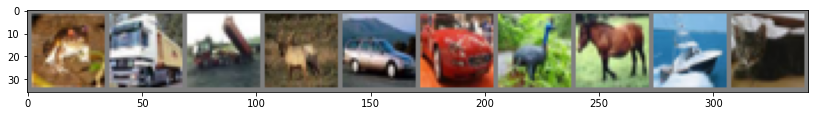

resolution: 16*16


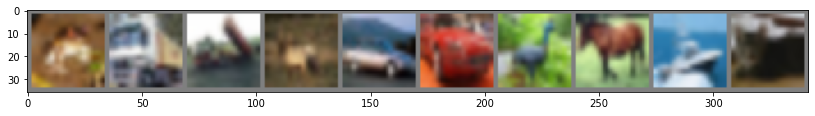

resolution: 8*8


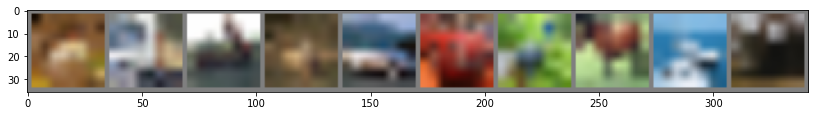

frog  truck truck deer  car   car   bird  horse ship  cat   deer  horse horse bird  truck truck truck cat   bird  frog  deer  cat   frog  frog  bird  frog  cat   dog   deer  plane plane truck car   cat   deer  plane cat   horse cat   cat   dog   bird  bird  horse car   car   car   bird  bird  plane truck dog   horse truck bird  bird  dog   bird  deer  cat   car   car   ship  bird 


In [40]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(14, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter_32 = iter(trainloader_32)
images_32, labels_32 = next(dataiter_32)
dataiter_16 = iter(trainloader_16)
images_16, labels_16 = next(dataiter_16)
dataiter_8 = iter(trainloader_8)
images_8, labels_8 = next(dataiter_8)
# show images
print('resolution: 32*32')
imshow(torchvision.utils.make_grid(images_32[0:10],nrow=10))
print('resolution: 16*16')
imshow(torchvision.utils.make_grid(images_16[0:10],nrow=10))
print('resolution: 8*8')
imshow(torchvision.utils.make_grid(images_8[0:10],nrow=10))

# print labels
print(' '.join(f'{classes[labels_32[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Model based on article architecture.

[Effects of Varying Resolution on Performance of CNN based Image Classification: An Experimental Study](https://www.researchgate.net/profile/Gaurav-Jaiswal-5/publication/328960034_Effects_of_Varying_Resolution_on_Performance_of_CNN_based_Image_Classification_An_Experimental_Study/links/5cbff689299bf120977ada45/Effects-of-Varying-Resolution-on-Performance-of-CNN-based-Image-Classification-An-Experimental-Study.pdf)



In [41]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv4 = nn.Conv2d(32, 64, 3)
        self.conv5 = nn.Conv2d(64, 64, 3)
        self.conv6 = nn.Conv2d(64, 64, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 3 * 3, 512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)


    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = self.pool1(x)
        #print(x.shape)
        x = self.dropout1(x)

        x = F.relu(self.conv4(x))
        #print(x.shape)
        x = F.relu(self.conv5(x))
        #print(x.shape)
        x = F.relu(self.conv6(x))
        #print(x.shape)
        x = self.pool2(x)
        #print(x.shape) 
        x = self.dropout2(x)
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        #print('x-shape:',x.shape)
        #print('output: ',x)
        #x = F.softmax(x,dim=1)
        #print('max:',x)

        return x


net = Net()

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [42]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [43]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=576, out_features=512, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [44]:
loss_train = []
for epoch in range(150):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader_32, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        #print('true labels:',labels)
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        #print(inputs.shape)
        # forward + backward + optimize
        outputs = net(inputs)
        #print('op:',outputs)
        #print('-----***----')
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 750 == 749:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 750:.3f}')
            loss_train.append(running_loss / 750)
            running_loss = 0.0

print('Finished Training')

[1,   750] loss: 2.303
[2,   750] loss: 2.303
[3,   750] loss: 2.302
[4,   750] loss: 2.302
[5,   750] loss: 2.297
[6,   750] loss: 2.154
[7,   750] loss: 1.991
[8,   750] loss: 1.903
[9,   750] loss: 1.848
[10,   750] loss: 1.787
[11,   750] loss: 1.729
[12,   750] loss: 1.674
[13,   750] loss: 1.619
[14,   750] loss: 1.572
[15,   750] loss: 1.537
[16,   750] loss: 1.503
[17,   750] loss: 1.473
[18,   750] loss: 1.444
[19,   750] loss: 1.418
[20,   750] loss: 1.391
[21,   750] loss: 1.363
[22,   750] loss: 1.337
[23,   750] loss: 1.313
[24,   750] loss: 1.285
[25,   750] loss: 1.260
[26,   750] loss: 1.238
[27,   750] loss: 1.216
[28,   750] loss: 1.196
[29,   750] loss: 1.175
[30,   750] loss: 1.160
[31,   750] loss: 1.141
[32,   750] loss: 1.120
[33,   750] loss: 1.101
[34,   750] loss: 1.086
[35,   750] loss: 1.072
[36,   750] loss: 1.055
[37,   750] loss: 1.041
[38,   750] loss: 1.029
[39,   750] loss: 1.014
[40,   750] loss: 1.006
[41,   750] loss: 0.987
[42,   750] loss: 0.977
[

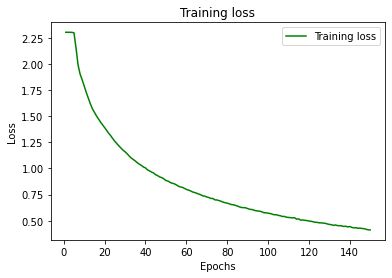

In [45]:
ep = range(1,151)
plt.plot(ep, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('re_32x32.png')
plt.show()

In [46]:
from torchsummary import summary
summary(net,(3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
            Conv2d-2           [-1, 32, 28, 28]           9,248
            Conv2d-3           [-1, 32, 26, 26]           9,248
         MaxPool2d-4           [-1, 32, 13, 13]               0
           Dropout-5           [-1, 32, 13, 13]               0
            Conv2d-6           [-1, 64, 11, 11]          18,496
            Conv2d-7             [-1, 64, 9, 9]          36,928
            Conv2d-8             [-1, 64, 7, 7]          36,928
         MaxPool2d-9             [-1, 64, 3, 3]               0
          Dropout-10             [-1, 64, 3, 3]               0
           Linear-11                  [-1, 512]         295,424
          Dropout-12                  [-1, 512]               0
           Linear-13                   [-1, 10]           5,130
Total params: 412,298
Trainable params:

Let's quickly save our trained model:



In [47]:
PATH1 = './cifar_net.pth'
torch.save(net.state_dict(), PATH1)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



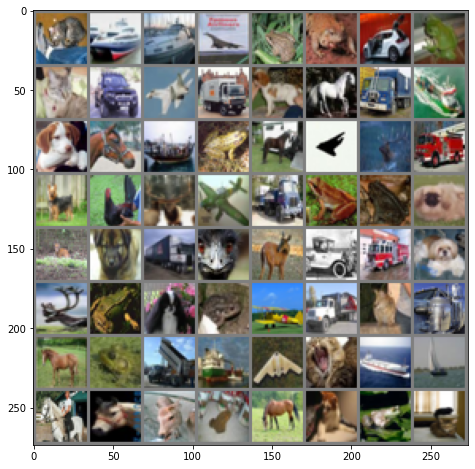

GroundTruth:  cat   ship  ship  plane


In [48]:
dataiter_32 = iter(testloader_32)
images, labels = next(dataiter_32)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [49]:
net_32 = Net()
net_32.load_state_dict(torch.load(PATH1))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [50]:
outputs = net_32(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [51]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [80]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader_32:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_32(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images-32: {100 * correct // total} %')
acc_32 = 100 * correct // total

Accuracy of the network on the 10000 test images-32: 74 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [81]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader_32:
        images, labels = data
        outputs = net_32(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class-32: {classname:5s} is {accuracy:.1f} %')

Accuracy for class-32: plane is 77.3 %
Accuracy for class-32: car   is 85.5 %
Accuracy for class-32: bird  is 62.0 %
Accuracy for class-32: cat   is 63.5 %
Accuracy for class-32: deer  is 72.6 %
Accuracy for class-32: dog   is 65.4 %
Accuracy for class-32: frog  is 84.9 %
Accuracy for class-32: horse is 75.0 %
Accuracy for class-32: ship  is 84.4 %
Accuracy for class-32: truck is 82.7 %


**F1 and Precition**

In [82]:
f1_32 = torchmetrics.F1Score(num_classes=10)
f1_score_32 = f1_32(predictions, labels).numpy()
print('f1: ',f1_score_32)
precision_32 = torchmetrics.functional.precision_recall(predictions, labels, num_classes=10)[0].numpy()
print('precition:',precision_32)

f1:  0.625
precition: 0.625



#Train 32x32 - Test 16x16



In [83]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader_16:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_32(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images-16: {100 * correct // total} %')
acc_16 = 100 * correct // total

Accuracy of the network on the 10000 test images-16: 41 %


In [84]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader_16:
        images, labels = data
        outputs = net_32(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class-16: {classname:5s} is {accuracy:.1f} %')

Accuracy for class-16: plane is 48.0 %
Accuracy for class-16: car   is 35.1 %
Accuracy for class-16: bird  is 48.5 %
Accuracy for class-16: cat   is 73.1 %
Accuracy for class-16: deer  is 41.2 %
Accuracy for class-16: dog   is 47.4 %
Accuracy for class-16: frog  is 12.5 %
Accuracy for class-16: horse is 30.8 %
Accuracy for class-16: ship  is 62.9 %
Accuracy for class-16: truck is 16.9 %


**F1 and precision**

In [85]:
f1_16 = torchmetrics.F1Score(num_classes=10)
f1_score_16 = f1_16(predictions, labels).numpy()
print('f1: ',f1_score_16)
precision_16 = torchmetrics.functional.precision_recall(predictions, labels, num_classes=10)[0].numpy()
print('precition:',precision_16)

f1:  0.3125
precition: 0.3125


#Train 32x32 - Test 8x8





In [86]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader_8:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_32(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images-8: {100 * correct // total} %')
acc_8 = 100 * correct // total

Accuracy of the network on the 10000 test images-8: 24 %


In [87]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader_8:
        images, labels = data
        outputs = net_32(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class-8: {classname:5s} is {accuracy:.1f} %')

Accuracy for class-8: plane is 27.5 %
Accuracy for class-8: car   is 4.8 %
Accuracy for class-8: bird  is 32.0 %
Accuracy for class-8: cat   is 72.0 %
Accuracy for class-8: deer  is 25.2 %
Accuracy for class-8: dog   is 30.2 %
Accuracy for class-8: frog  is 3.3 %
Accuracy for class-8: horse is 4.4 %
Accuracy for class-8: ship  is 44.5 %
Accuracy for class-8: truck is 0.2 %


**F1 and Precision**

In [88]:
f1_8 = torchmetrics.F1Score(num_classes=10)
f1_score_8 = f1_8(predictions, labels).numpy()
print('f1: ',f1_score_8)
precision_8 = torchmetrics.functional.precision_recall(predictions, labels, num_classes=10)[0].numpy()
print('precition:',precision_8)

f1:  0.3125
precition: 0.3125


# TVTV 

# Train 16x16 - Test 16x16

**Train model 16x16**

In [60]:
loss_train = []
for epoch in range(150):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader_16, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        #print('true labels:',labels)
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        #print(inputs.shape)
        # forward + backward + optimize
        outputs = net(inputs)
        #print('op:',outputs)
        #print('-----***----')
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 750 == 749:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 750:.3f}')
            loss_train.append(running_loss / 750)
            running_loss = 0.0

print('Finished Training')

[1,   750] loss: 0.854
[2,   750] loss: 0.775
[3,   750] loss: 0.751
[4,   750] loss: 0.738
[5,   750] loss: 0.723
[6,   750] loss: 0.710
[7,   750] loss: 0.697
[8,   750] loss: 0.693
[9,   750] loss: 0.678
[10,   750] loss: 0.675
[11,   750] loss: 0.669
[12,   750] loss: 0.661
[13,   750] loss: 0.655
[14,   750] loss: 0.650
[15,   750] loss: 0.641
[16,   750] loss: 0.636
[17,   750] loss: 0.636
[18,   750] loss: 0.628
[19,   750] loss: 0.621
[20,   750] loss: 0.613
[21,   750] loss: 0.609
[22,   750] loss: 0.609
[23,   750] loss: 0.606
[24,   750] loss: 0.604
[25,   750] loss: 0.596
[26,   750] loss: 0.592
[27,   750] loss: 0.587
[28,   750] loss: 0.586
[29,   750] loss: 0.583
[30,   750] loss: 0.581
[31,   750] loss: 0.576
[32,   750] loss: 0.571
[33,   750] loss: 0.566
[34,   750] loss: 0.564
[35,   750] loss: 0.558
[36,   750] loss: 0.555
[37,   750] loss: 0.555
[38,   750] loss: 0.551
[39,   750] loss: 0.546
[40,   750] loss: 0.540
[41,   750] loss: 0.538
[42,   750] loss: 0.536
[

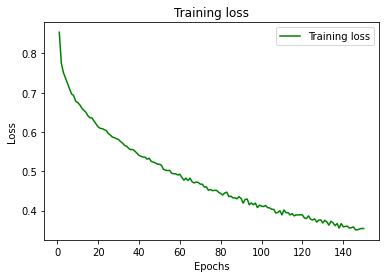

In [61]:
ep = range(1,151)
plt.plot(ep, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('re_16x16.png')
plt.show()

**Save model**

In [62]:
PATH2 = './cifar_net16.pth'
torch.save(net.state_dict(), PATH2)
net_16 = Net()
net_16.load_state_dict(torch.load(PATH2))


<All keys matched successfully>

Accuracy

In [89]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader_16:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_16(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images-16: {100 * correct // total} %')
acc_16_b = 100 * correct // total

Accuracy of the network on the 10000 test images-16: 70 %


In [90]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader_16:
        images, labels = data
        outputs = net_16(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class-8: {classname:5s} is {accuracy:.1f} %')

Accuracy for class-8: plane is 67.4 %
Accuracy for class-8: car   is 83.6 %
Accuracy for class-8: bird  is 62.6 %
Accuracy for class-8: cat   is 55.1 %
Accuracy for class-8: deer  is 63.2 %
Accuracy for class-8: dog   is 62.5 %
Accuracy for class-8: frog  is 73.9 %
Accuracy for class-8: horse is 75.9 %
Accuracy for class-8: ship  is 79.9 %
Accuracy for class-8: truck is 78.3 %


**F1 and Precision**

In [91]:
f1_16_b = torchmetrics.F1Score(num_classes=10)
f1_score_16_b = f1_16_b(predictions, labels).numpy()
print('f1: ',f1_score_16_b)
precision_16_b = torchmetrics.functional.precision_recall(predictions, labels, num_classes=10)[0].numpy()
print('precition:',precision_16_b)

f1:  0.75
precition: 0.75


#Train 8x8 - Test 8x8

**Train model 16x16**

In [66]:
loss_train = []
for epoch in range(150):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader_8, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        #print('true labels:',labels)
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        #print(inputs.shape)
        # forward + backward + optimize
        outputs = net(inputs)
        #print('op:',outputs)
        #print('-----***----')
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 750 == 749:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 750:.3f}')
            loss_train.append(running_loss / 750)
            running_loss = 0.0

[1,   750] loss: 1.234
[2,   750] loss: 1.139
[3,   750] loss: 1.107
[4,   750] loss: 1.076
[5,   750] loss: 1.059
[6,   750] loss: 1.041
[7,   750] loss: 1.029
[8,   750] loss: 1.014
[9,   750] loss: 1.003
[10,   750] loss: 0.993
[11,   750] loss: 0.982
[12,   750] loss: 0.980
[13,   750] loss: 0.966
[14,   750] loss: 0.960
[15,   750] loss: 0.951
[16,   750] loss: 0.946
[17,   750] loss: 0.931
[18,   750] loss: 0.928
[19,   750] loss: 0.923
[20,   750] loss: 0.914
[21,   750] loss: 0.914
[22,   750] loss: 0.909
[23,   750] loss: 0.899
[24,   750] loss: 0.894
[25,   750] loss: 0.885
[26,   750] loss: 0.880
[27,   750] loss: 0.875
[28,   750] loss: 0.872
[29,   750] loss: 0.866
[30,   750] loss: 0.862
[31,   750] loss: 0.857
[32,   750] loss: 0.851
[33,   750] loss: 0.851
[34,   750] loss: 0.839
[35,   750] loss: 0.838
[36,   750] loss: 0.835
[37,   750] loss: 0.828
[38,   750] loss: 0.825
[39,   750] loss: 0.821
[40,   750] loss: 0.813
[41,   750] loss: 0.818
[42,   750] loss: 0.810
[

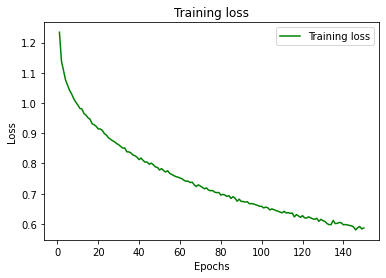

In [67]:
ep = range(1,151)
plt.plot(ep, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('re_8x8.png')
plt.show()

**Save model**

In [68]:
PATH3 = './cifar_net8.pth'
torch.save(net.state_dict(), PATH3)
net_8 = Net()
net_8.load_state_dict(torch.load(PATH3))

<All keys matched successfully>

Accuracy

In [92]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader_8:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_8(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images-16: {100 * correct // total} %')
acc_8_b = 100 * correct // total

Accuracy of the network on the 10000 test images-16: 59 %


In [93]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader_8:
        images, labels = data
        outputs = net_8(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class-8: {classname:5s} is {accuracy:.1f} %')

Accuracy for class-8: plane is 63.2 %
Accuracy for class-8: car   is 66.0 %
Accuracy for class-8: bird  is 41.5 %
Accuracy for class-8: cat   is 48.9 %
Accuracy for class-8: deer  is 50.7 %
Accuracy for class-8: dog   is 51.1 %
Accuracy for class-8: frog  is 61.8 %
Accuracy for class-8: horse is 67.5 %
Accuracy for class-8: ship  is 70.8 %
Accuracy for class-8: truck is 69.7 %


**F1 and Precision**

In [94]:
f1_8_b = torchmetrics.F1Score(num_classes=10)
f1_score_8_b = f1_8_b(predictions, labels).numpy()
print('f1: ',f1_score_8_b)
precision_8_b = torchmetrics.functional.precision_recall(predictions, labels, num_classes=10)[0].numpy()
print('precition:',precision_8_b)

f1:  0.5
precition: 0.5


# Compare metrics

**Accuracy**

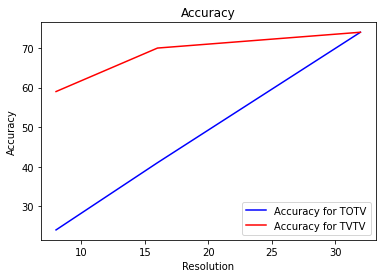

In [101]:
reso = [32,16,8]
accs = [acc_32,acc_16,acc_8]
accs_b = [acc_32,acc_16_b,acc_8_b]

plt.plot(reso, accs, 'b', label='Accuracy for TOTV')
plt.plot(reso, accs_b, 'r', label='Accuracy for TVTV')
plt.title('Accuracy')
plt.xlabel('Resolution')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('cmp_acc.png')
plt.show()

**Precision**

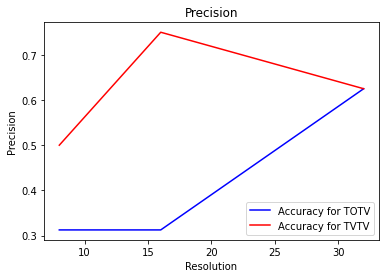

In [99]:
pr = [precision_32,precision_16,precision_8]
pr_b = [precision_32,precision_16_b,precision_8_b]
plt.plot(reso, pr, 'b', label='Accuracy for TOTV')
plt.plot(reso, pr_b, 'r', label='Accuracy for TVTV')
plt.title('Precision')
plt.xlabel('Resolution')
plt.ylabel('Precision')
plt.legend()
plt.savefig('cmp_precision.png')
plt.show()

**F1-score**

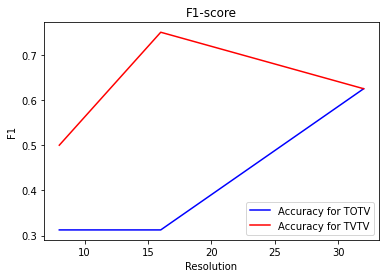

In [102]:
f1_scores = [f1_score_32,f1_score_16,f1_score_8]
f1_scores_b = [f1_score_32,f1_score_16_b,f1_score_8_b]
plt.plot(reso, f1_scores, 'b', label='Accuracy for TOTV')
plt.plot(reso, f1_scores_b, 'r', label='Accuracy for TVTV')
plt.title('F1-score')
plt.xlabel('Resolution')
plt.ylabel('F1')
plt.legend()
plt.savefig('cmp_f1.png')
plt.show()